<a href="https://colab.research.google.com/github/ChrisKantor/Deep-Learning/blob/main/Project%202/Deep_Learning_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Deep learning model that builds on the one made in HW3 for determining an infants pain level using vital signs
#This improved model uses LSTM to better understand the sequential readings



#Run these commands - NECCESARY to use the GPU
# export CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))
# export LD_LIBRARY_PATH=${CUDNN_PATH}/lib

#To connect to local runtime: jupyter lab --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

In [299]:
#import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import os
from matplotlib import pyplot as plt
import PIL
from tensorflow import keras

#needed for peephole lstm cell as tensorflow doesn't have native support yet
!pip install tensorflow_addons
import tensorflow_addons as tfa

#potential definition of peephole LSTM cell to get around using the soon to be deprecated tfa verion
#taken from here: https://github.com/tensorflow/tensorflow/blob/97f585d506cccc57dc98f234f4d5fcd824dd3c03/tensorflow/python/ops/rnn_cell.py#L353

In [300]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# dir = 'Deep Learning/Project 2/'
# data_dir = "data/"


## Mount Google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Project 2/data/'


import os
print(os.getcwd())

Num GPUs Available:  0
Mounted at /content/drive
/content


# Data Preprocessing

In [301]:
#store a list of dataframes representing the data from the csv files we read in
#after reading in all of the csv files as dataframes, iterate through them, cleaning up the data and normalizing the inputs


#Should we normalize on a dataframe level or a dataset level?


data = []


#use the os library to iterate through all files in the current path
for (root,dirs,files) in os.walk(data_dir, topdown=True):
  #open each CSV file, we don't want to open any other type of file
  for f in files:
    if f.endswith(".csv"):
      with open(os.path.join(root, f), mode ='r') as csvFile:

        #read in the csv file
        csvData = csv.reader(csvFile)

        #store the data temporarily before we turn it into a pandas dataframe
        temp = []


        #check if each row is valid
        #one way to tell if the data is invalid is if the label is NOT [0, 1, 2]. This means there was something wrong with one of the sensors at the time of capture
        #another way is to check if the heart rate, respiratory rate, or o2 level is too low or too high
        #for heart Rate, we want a range of 40 - 200
        #for Respiratory Rate, we want a range of 15 - 90
        #for o2 level, we want a rate of 80 - 100

        for row in csvData:
          try:
            if row[4] in "012" and (int(row[1]) >= 40 and int(row[1]) <= 200) and (int(row[2]) >= 15 and int(row[2]) <= 90) and (int(row[3]) >= 80 and int(row[3]) <= 100):   #data is valid, so add it to the main csv
              #row[0] just stores the row # in the csv file, so it is not needed in the training dataset
              temp.append([int(row[1]), int(row[2]), int(row[3]), int(row[4])])

          #Catches errors that occur when an element cannot be parsed into an integer. In this case the row is invalid so we can skip it
          except ValueError:
            continue

        #if this valid and cleaned sequence is NOT empty, add it to our dataset
        if len(temp) > 0:
          df = pd.DataFrame(temp, columns = ['Heart Rate', 'Respiratory Rate', 'O2 Level', 'Label'])
          data.append(df)

print(len(data))

487


In [302]:
#count sequence lengths and how often they appear
freqMap = {}
for d in data:
  if d.shape not in freqMap.keys():
    freqMap[d.shape] = 1

  else:
    freqMap[d.shape] += 1

for key, value in freqMap.items():
    print(f'{key} -> {value}')


#split data into training/validation sets using an 90/10 split
data = np.asarray(data, dtype="object")
np.random.shuffle(data)

trainData, valData = np.split(data, [int(0.90*len(data))])

print(len(trainData), len(valData))

#remove the labels from the trainingData and validation data, also storing them as a list
#we don't need the entire column of labels, just the first rows label
trainLabels = []
valLabels = []

for df in trainData:
  label = df['Label'].iloc[0]    #get the first rows label, and use it for this whole sequence
  df.drop('Label', axis=1, inplace=True)
  trainLabels.append(label)

for df in valData:
  label = df['Label'].iloc[0]    #get the first rows label, and use it for this whole sequence
  df.drop('Label', axis=1, inplace=True)
  valLabels.append(label)

trainLabels = np.asarray(trainLabels).astype('int32')
valLabels = np.asarray(valLabels).astype('int32')
print(trainData.shape, len(trainLabels))
print(valData.shape, len(valLabels))

trainLabelMap = {}
for label in trainLabels:
  if label not in trainLabelMap.keys():
    trainLabelMap[label] = 1
  else:
    trainLabelMap[label] += 1


valLabelMap = {}
for label in valLabels:
  if label not in valLabelMap.keys():
    valLabelMap[label] = 1
  else:
    valLabelMap[label] += 1

print(trainLabelMap)
print(valLabelMap)

(31, 4) -> 381
(30, 4) -> 31
(14, 4) -> 2
(29, 4) -> 21
(5, 4) -> 1
(11, 4) -> 1
(21, 4) -> 4
(4, 4) -> 1
(7, 4) -> 1
(27, 4) -> 10
(28, 4) -> 15
(25, 4) -> 4
(26, 4) -> 6
(17, 4) -> 2
(22, 4) -> 2
(24, 4) -> 2
(23, 4) -> 2
(15, 4) -> 1
438 49
(438,) 438
(49,) 49
{0: 247, 1: 163, 2: 28}
{0: 31, 1: 16, 2: 2}


In [303]:
#normalize data using only the training set
#save the values, then iterate through the training and validation dataset and use min-max normalization
#df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

#[[Heart Rate Min, Heart Rate Max], [Respiratory Rate Min, Respiratory Rate Max], [O2 Level Min, O2 Level Max]]

normValues = [[40, 200], [15, 90], [80, 100]]   #from data cleaning

print(normValues)



#normalizing the data:
for df in trainData:
  df['Heart Rate'] = (df['Heart Rate'] - normValues[0][0]) / (normValues[0][1] - normValues[0][0])
  df['Respiratory Rate'] = (df['Respiratory Rate'] - normValues[1][0]) / (normValues[1][1] - normValues[1][0])
  df['O2 Level'] = (df['O2 Level'] - normValues[2][0]) / (normValues[2][1] - normValues[2][0])

for df in valData:
  df['Heart Rate'] = (df['Heart Rate'] - normValues[0][0]) / (normValues[0][1] - normValues[0][0])
  df['Respiratory Rate'] = (df['Respiratory Rate'] - normValues[1][0]) / (normValues[1][1] - normValues[1][0])
  df['O2 Level'] = (df['O2 Level'] - normValues[2][0]) / (normValues[2][1] - normValues[2][0])

[[40, 200], [15, 90], [80, 100]]


In [304]:
#Data Augmentation
#randomly select sequences from the training dataset by picking random indices (to also save the correct labels)
#remove some random amout of entries from the end of these sequences, and save them as new ones

import random

print(trainData.shape, len(trainLabels))

#using a 50% chance to augment a sequence
aug_idx = []
aug_train_data = []
aug_labels = []

for i in range(len(trainData)):
  if random.random() >= 0.50:
    aug_idx.append(i)

print(len(aug_idx))
print(aug_idx)

#now we have a list of indices we want to augment

for idx in aug_idx:

  #copy seq we want to augment and its label
  aug = trainData[idx]
  label = trainLabels[idx]

  #randomly drop between 1 element to 50% of elements from the end of this sequence, then save it as a new sequence
  drop = int(random.randint(1, int(aug.shape[0] * 0.50)))
  aug = df.drop(df.tail(drop).index)

  if aug.shape[0] > 31:
    print("ERROR: ", aug.shape)

  aug_train_data.append(aug)
  aug_labels.append(label)

print(len(aug_train_data), len(aug_labels))

#now add the augmented data and labels to the original lists

#convert original data/label np arrays back to python lists
trainData = trainData.tolist()
trainLabels = trainLabels.tolist()

#add our augmented data to the end of these lists
trainData.extend(aug_train_data)
trainLabels.extend(aug_labels)

#convert the arrays back to np arrays
trainData = np.asarray(trainData, dtype="object")
trainLabels = np.array(trainLabels)

print(trainData.shape, len(trainLabels))

(438,) 438
217
[4, 5, 6, 7, 8, 9, 10, 11, 14, 18, 19, 20, 23, 24, 25, 26, 31, 34, 35, 36, 39, 40, 43, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 60, 61, 63, 66, 69, 72, 75, 76, 78, 80, 83, 84, 85, 86, 88, 89, 91, 94, 95, 97, 100, 107, 112, 113, 116, 117, 119, 121, 122, 124, 125, 127, 131, 132, 133, 134, 135, 138, 139, 144, 145, 146, 149, 150, 153, 154, 158, 159, 162, 164, 166, 167, 169, 170, 172, 174, 175, 181, 183, 185, 186, 187, 188, 189, 190, 193, 194, 197, 198, 200, 201, 205, 206, 207, 208, 209, 213, 218, 219, 224, 229, 231, 232, 235, 236, 237, 239, 240, 243, 247, 249, 250, 252, 253, 256, 257, 260, 261, 266, 270, 271, 272, 273, 275, 276, 277, 278, 279, 283, 285, 286, 287, 288, 291, 292, 293, 294, 296, 297, 298, 299, 304, 305, 308, 310, 311, 316, 319, 322, 323, 329, 330, 337, 338, 339, 341, 343, 345, 348, 349, 353, 354, 355, 357, 358, 359, 360, 362, 363, 364, 365, 368, 370, 372, 374, 375, 377, 382, 384, 385, 392, 395, 396, 399, 403, 405, 406, 410, 412, 414, 417, 418, 419, 424, 

In [305]:
#Data padding
#inputs to GRU cells are in the form of [batch, timesteps, feature]
#our sequences have multiple lengths, so we need to pad this data to get all of the sequences to have a length of 31 (indices 0-30)
#we can pad the data by adding rows of 0's, and use a masking layer to ignore them when training the model

for i in range(len(trainData)):
  if trainData[i].shape[0] < 31:
    padding = pd.DataFrame(0, index=np.arange(trainData[i].shape[0], 31), columns=trainData[i].columns)
    trainData[i] = pd.concat([trainData[i], padding])

for i in range(len(valData)):
  if valData[i].shape[0] < 31:
    padding = pd.DataFrame(0, index=np.arange(valData[i].shape[0], 31), columns=valData[i].columns)
    valData[i] = pd.concat([valData[i], padding])

In [306]:
#convert dataframes into np arrays and make the whole dataset multidimensional instead of an array of dataframes for tensorflow to properly use
trainData = np.array([np.array(val) for val in trainData])
valData = np.array([np.array(val) for val in valData])

# Model Setup

In [307]:
#need to seed initialization
seed = 8312001

tf.keras.utils.set_random_seed(seed)

In [308]:
#input is taken in the form of: [batch, timesteps, feature]

input = tf.keras.layers.Input(shape=(31, 3))
mask = tf.keras.layers.Masking(mask_value=0., input_shape=(31, 3)) (input)
x = (tf.keras.layers.LSTM(32, return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2(), recurrent_regularizer = tf.keras.regularizers.l2())) (mask)
# x = (tf.keras.layers.LSTM(32, return_sequences=True, return_state=True, kernel_regularizer = tf.keras.regularizers.l2(), recurrent_regularizer = tf.keras.regularizers.l2())) (x)
# x = (tf.keras.layers.LSTM(32, return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2(), recurrent_regularizer = tf.keras.regularizers.l2())) (x)
x = (tf.keras.layers.Flatten()) (x)
x = (tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l2())) (x)
output = (tf.keras.layers.Dense(3)) (x)

model = keras.Model(input, output, name="LSTM_Model")

In [309]:
#Peephole LSTM Model
#uses the tfa PeepholeLSTMCell, which is equivalent to the normal tf LSTMCell, but adds peephole connections
#soon to be deprecated

input = tf.keras.layers.Input(shape=(31, 3))
mask = tf.keras.layers.Masking(mask_value=0., input_shape=(31, 3)) (input)

Peep_LSTMCell = tfa.rnn.PeepholeLSTMCell(32, kernel_regularizer = tf.keras.regularizers.l2(), recurrent_regularizer = tf.keras.regularizers.l2())

x = (tf.keras.layers.RNN(Peep_LSTMCell, return_sequences=True)) (mask)
# x = (tf.keras.layers.RNN(Peep_LSTMCell, return_sequences=True)) (x)
# x = (tf.keras.layers.RNN(Peep_LSTMCell, return_sequences=True, return_state=True)) (x)
# x = (tf.keras.layers.RNN(Peep_LSTMCell, return_sequences=True)) (x)
x = (tf.keras.layers.Flatten()) (x)
x = (tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l2())) (x)
# x = (tf.keras.layers.Dropout(0.5)) (x)
# x = (tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l2())) (x)
output = (tf.keras.layers.Dense(3)) (x)

peep_model = keras.Model(input, output, name="Peephole_LSTM_Model")


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


# Model Training

In [310]:
models = [model, peep_model]

model = model

In [311]:
#our learning rate scheduler. Will gradually shrink the learning rate as training progesses to find a better converging point.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Project 2/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#early stopping callback. stop if the loss doesn't improve for 7 epochs in a row
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=5,
    start_from_epoch=20)


opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt,
              loss=loss_fn,
              metrics=['accuracy'])
model.summary()

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 31, 3)]           0         
                                                                 
 masking_32 (Masking)        (None, 31, 3)             0         
                                                                 
 lstm_25 (LSTM)              (None, 31, 32)            4608      
                                                                 
 flatten_32 (Flatten)        (None, 992)               0         
                                                                 
 dense_65 (Dense)            (None, 64)                63552     
                                                                 
 dense_66 (Dense)            (None, 3)                 195       
                                                                 
Total params: 68355 (267.01 KB)
Trainable params: 68355 

In [312]:
#train the model
#Some hyperparameter setup
batch_size = 256           #set batch size to 256
epochs = 100               #set num epochs to 100

history = model.fit(
    trainData,
    trainLabels,
    validation_data=(valData, valLabels),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/100
3/3 [==============================] - 16s 906ms/step - loss: 2.5719 - accuracy: 0.5206 - val_loss: 2.3030 - val_accuracy: 0.6327
Epoch 2/100
3/3 [==============================] - 0s 66ms/step - loss: 2.3341 - accuracy: 0.5603 - val_loss: 2.1979 - val_accuracy: 0.6327
Epoch 3/100
3/3 [==============================] - 0s 116ms/step - loss: 2.2389 - accuracy: 0.5603 - val_loss: 2.0973 - val_accuracy: 0.6531
Epoch 4/100
3/3 [==============================] - 0s 63ms/step - loss: 2.1375 - accuracy: 0.5573 - val_loss: 1.9933 - val_accuracy: 0.6327
Epoch 5/100
3/3 [==============================] - 0s 61ms/step - loss: 2.0352 - accuracy: 0.5511 - val_loss: 1.8918 - val_accuracy: 0.6327
Epoch 6/100
3/3 [==============================] - 0s 69ms/step - loss: 1.9400 - accuracy: 0.5527 - val_loss: 1.8029 - val_accuracy: 0.6327
Epoch 7/100
3/3 [==============================] - 0s 70ms/step - loss: 1.8519 - accuracy: 0.5573 - val_loss: 1.7322 - val_accuracy: 0.6531
Epoch 8/100
3/3 [

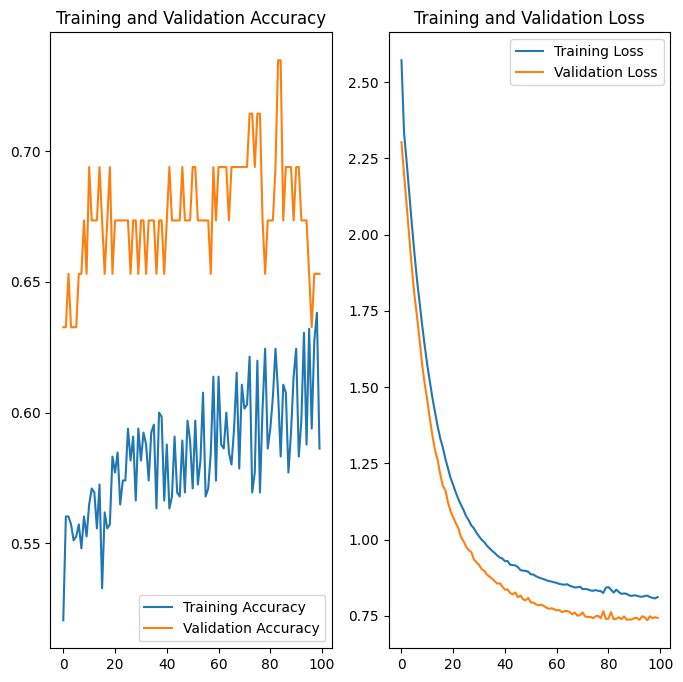

In [313]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(min(epochs, len(acc)))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [314]:
#load the best model using the callback
model.load_weights(checkpoint_filepath)

print("\n\nEvaluating Best Model\n")
#evaluation the model on the validation data
model.evaluate(valData, valLabels, verbose=2)


#Best val acc so far: 0.816 w/ 0.75 test acc



Evaluating Best Model

2/2 - 0s - loss: 0.7400 - accuracy: 0.7347 - 68ms/epoch - 34ms/step


[0.7400217056274414, 0.7346938848495483]

In [ ]:
#save the model
model.save("/content/drive/MyDrive/Colab Notebooks/Deep Learning/Project 2/bestModel_LSTM.keras")
print("Saved Model")

Saved Model


# Testing Script

In [298]:
#import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
import os
from matplotlib import pyplot as plt


# ## Mount Google drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# data_dir = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Project 2/'

###############################################################################
#Reading data and normalization

#read test.csv, dropping the first column as it just holds the index of the rows, which we don't need
testData = pd.read_csv("test.csv", sep=',', usecols=[1, 2, 3, 4], names = ['Heart Rate', 'Respiratory Rate', 'O2 Level', 'Label'])


#Normalize the test data using the normalization factors we found in the training data. Hard coded here
normValues = [[40, 200], [15, 90], [80, 100]]   #from training
testData['Heart Rate'] = (testData['Heart Rate'] - normValues[0][0]) / (normValues[0][1] - normValues[0][0])
testData['Respiratory Rate'] = (testData['Respiratory Rate'] - normValues[1][0]) / (normValues[1][1] - normValues[1][0])
testData['O2 Level'] = (testData['O2 Level'] - normValues[2][0]) / (normValues[2][1] - normValues[2][0])


###############################################################################
#now we need to process the data by seperating the entire data array into 31 row chunks
testData = np.array_split(testData, np.arange(31, len(testData), 31))

#pull the labels from the first row of each sequence, save it to an array, then drop the label col from this data sequence
testLabels = []
for seq in testData:
  label = seq['Label'].iloc[0]    #get the first rows label, and use it for this whole sequence
  seq.drop('Label', axis=1, inplace=True)
  testLabels.append(label)

testLabels = np.asarray(testLabels).astype('int32')

#convert dataframes into np arrays and make the whole dataset multidimensional instead of an array of dataframes for tensorflow to properly use
testData = np.array([np.array(seq) for seq in testData])

###############################################################################
#Testing model
#load the model from a saved file
bestmodel = tf.keras.models.load_model(data_dir + "bestModel_LSTM.keras")

#evaluating the model on the test data
loss, acc = bestmodel.evaluate(testData, testLabels, verbose=2)
print("Loss on test data: ", loss)
print("Accuracy on test data: ", acc)

Mounted at /content/drive
1/1 - 0s - loss: 0.8242 - accuracy: 0.7500 - 38ms/epoch - 38ms/step
Loss on test data:  0.8242024183273315
Accuracy on test data:  0.75
1/1 - 3s - loss: 0.7477 - accuracy: 0.7500 - 3s/epoch - 3s/step
Loss on test data:  0.7477211952209473
Accuracy on test data:  0.75
